# Metastatic Cell Lines DESeq Analysis

In [1]:
import pandas as pd
import numpy as np
import pymongo
import os
import pysam
from statsmodels.stats.multitest import fdrcorrection
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels
import seaborn as sns
import random
import re
import json as js
import warnings
warnings.filterwarnings("ignore")
import rpy2.ipython
%load_ext rpy2.ipython

In [2]:
%%R 
library(DESeq2)
library(EnhancedVolcano)

R[write to console]: Loading required package: S4Vectors

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int

## Load Counts

In [3]:
with open('data/counts/cell_lines_exRNA_filtered_loci_counts.json', 'r') as f:
    ex_fil_sample_loci = js.load(f)
    f.close()

In [4]:
sig_brca_sig_cl_df = pd.read_csv("results/thresholds/15%_fdr_tcga.bed", header=None, sep="\t")

In [5]:
met_par_counts = {}
for cell_line, loci_dict in ex_fil_sample_loci.items():
    if "LM2" in cell_line or "MDA231" in cell_line or "CN34" in cell_line or "LM1a" in cell_line:
        met_par_counts[cell_line] = loci_dict
len(met_par_counts)

8

In [6]:
sig_loci_counts = {} #Use the raw counts
for locus in sig_brca_sig_cl_df[3]:
    sig_loci_counts[locus] = {} 
    for cell_line, loci_dict in met_par_counts.items():
        if locus in loci_dict:
            sig_loci_counts[locus][cell_line] = loci_dict[locus]
        else:
            sig_loci_counts[locus][cell_line] = 0

In [7]:
met_par_cm = pd.DataFrame(sig_loci_counts).T
met_par_cm = met_par_cm.sort_index(axis=1)
met_par_cm

,CN34_1_cell_S27,CN34_2_cell_S38,LM1a_1_cell_S28,LM1a_2_cell_S39,LM2_1_cell_S26,LM2_2_cell_S37,MDA231_1_cell_S25,MDA231_2_cell_S36
chr1:153968073-153968151:-,0,0,0,0,0,0,0,0
chr1:202012878-202012954:+,0,0,0,1,0,0,0,0
chr5:179616958-179617066:-,3,1,2,2,2,2,0,0
chr7:29921213-29921331:-,10,4,7,14,6,0,6,5
chr7:44798789-44798846:+,3,1,8,6,2,0,2,2
...,...,...,...,...,...,...,...,...
chr7:5064310-5064536:+,2,1,2,6,3,0,2,4
chr11:10797531-10797670:-,5,5,4,11,0,0,1,4
chr19:39378436-39378499:+,0,1,1,1,0,0,1,2
chr11:69653405-69653497:+,3,2,1,3,5,1,3,4


In [8]:
coldata = pd.DataFrame({"condition": ["Par", "Par", "Met", "Met", "Met", "Met", "Par", "Par"], 
                        "type":["single_read", "single_read", "single_read", "single_read", "single_read", "single_read", "single_read", "single_read"],
                       "background":["CN34", "CN34", "CN34", "CN34", "MDA231", "MDA231", "MDA231", "MDA231"]})
coldata.index=met_par_cm.columns
coldata

,condition,type,background
CN34_1_cell_S27,Par,single_read,CN34
CN34_2_cell_S38,Par,single_read,CN34
LM1a_1_cell_S28,Met,single_read,CN34
LM1a_2_cell_S39,Met,single_read,CN34
LM2_1_cell_S26,Met,single_read,MDA231
LM2_2_cell_S37,Met,single_read,MDA231
MDA231_1_cell_S25,Par,single_read,MDA231
MDA231_2_cell_S36,Par,single_read,MDA231


In [9]:
%%R -i coldata,met_par_cm
dds <- DESeqDataSetFromMatrix(countData = met_par_cm, colData = coldata, design = ~ condition+background)
dds <- DESeq(dds)

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



In [10]:
%%R -o dds_res
dds_res <- as.data.frame(results(dds, contrast=c("condition", "Met", "Par"), tidy=TRUE))
dds_res <- dds_res[!is.na(dds_res$padj),]

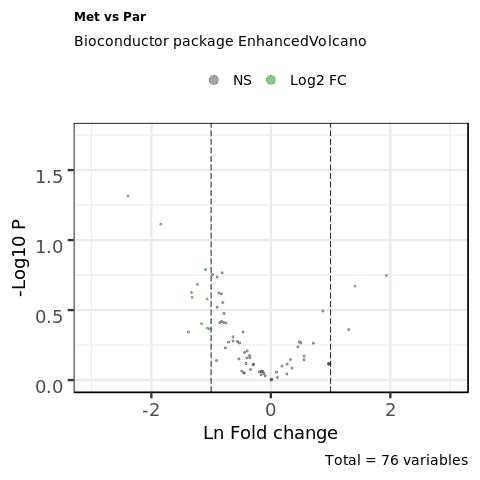

In [11]:
%%R
pdf('figures/metvparDE.pdf')
p <- EnhancedVolcano(dds_res, lab = dds_res$row, x= "log2FoldChange", xlab="Ln Fold change",
                          y="pvalue", ylab="-Log10 P", title= "Met vs Par",
                          titleLabSize = 12, border = "full", FCcutoff=1, xlim = c(-3,3),
                          ylim=c(0,1.75)
)
print(p)
dev.off()
p

# Conclusion
From our pool of cancer-specific RNAs, we do not identify RNAs that are upregulated in metastatic cell lines in comparison to their parental low-metastatic counterpart.